We will cover convolutional neural networks. You can think of CNN's as a neural network with a slightly different architecture, or that the weights are "wired" differently. These weights (parameters) still can be optimized via gradient descent, and we will still use the back-propagation algorithm.

# Convolutional Neural Networks
The workhorse of modern image processing
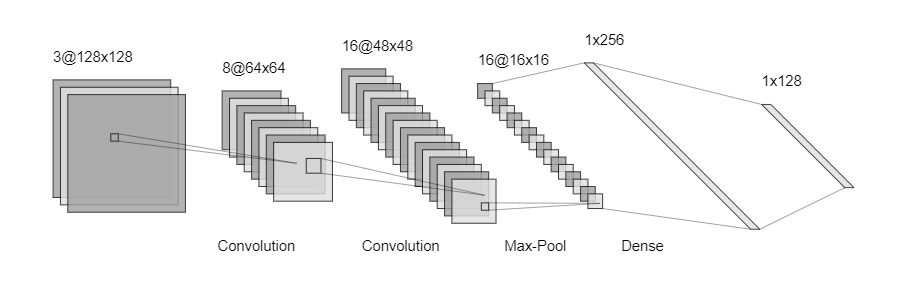

## Terminology
**Abreviation**: often called "CNNs" or Conv Nets

**Convolutional layer**: A set of kernels + bias terms (usually referring to 2D convolutions)

**Pooling Layers:** Typically used to reduce spatial dimensions

**Channels:**

We will often talk about **channels**, which for an image is RGB (maybe D), however is a more abstract concept for a CNN. In a CNN each channel is simply the non-spatial dimension (for example $32\times 32 \times 8$). Looking at the example above we can see the channel is the number of grey boxes, moving from 3 to 8 to 16.

The number of channels is also the same as the number of kernels.

## Another Example
Lets look at a slightly different architecture which does a 10-way classification of 64x64 RGB images

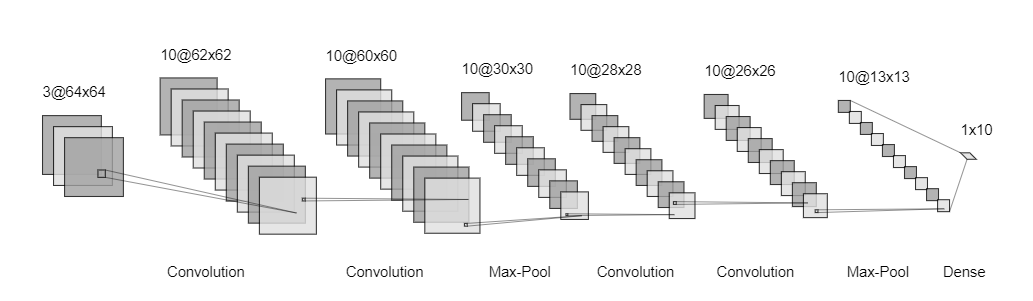


## Interactive Example

[Interactive CNN](https://poloclub.github.io/cnn-explainer/)

## Mathematics of Conv Nets

Lets take a brief look at the operations occuring at each layer in our CNN.

### 2D Convolution

The most common operation, applies a convolutional kernel over a 2D spatial domain. However, this doesn't mean the operator is 2D! For a single kernel we want to transform our image representation into a 2D "activation map". 

Basically we want to go from $H\times W \times C$ to $\tilde{H} \times \tilde{W}$. The ~ is to signify that the spatial dimensions might change a little due to edge effects. 

The 2D convolution operator will handle the spatial dimensions, as it by definition will "scan" over the entire image. How is the channel dimension handeled?



Our convolutional kernels require a channel dimension to work properly. 

This is often implied by the context of the layer and not declared directly. In the first layer of the example network we apply a 3x3 convolution on an RGB image. In reality this "3x3" convolution actually has kernels which are "3x3x3".

## Understanding the API
While a firm mathematical understanding is useful, for the most part the math is handled by a machine learning framework. Lets take a look at how tensorflow allows you to define convolutional layers and what each of the parameters mean:

I like the keras documentation: [Conv2D layer](https://keras.io/api/layers/convolution_layers/convolution2d/)


```
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```

### filters
- The number of convolutions you want to apply to the input. In our example above we were using 10.

### kernel_size
- The size of the filter you want to use for the convolution operation
- You can specify either a single number for a square kernel (typical) or two numbers to specify the `x` and `y` dimensions
- The "depth" of the filter (the number of channels in the prior layer) is handled implicitly in keras

### strides
- The typical discrete convolution you learned in a signal processing class looks like this:

$$ (f*g)[n] = \sum_{m = -\infty}^\infty f[m]g[n-m]$$

Of course for a 3x3 kernel this looks like (here the kernel is "f"):

$$ (f*g)[n] = \sum_{m = -1}^1 f[m]g[n-m]$$

This means that, except for edges, for every input position "n" we have an output. The stride controls this by limiting the values "n" over which our operation is evaluated on, for example with a stride of 2:

$$ \begin{cases} (f*g)[n] = \sum_{m = -1}^1 f[m]g[n-m] & \text{even n} \\ \text{not defined} & \text{odd n}\end{cases}$$

This is a complicated way of saying stride controls the interval of $n$ which we apply our convolution expression on. You can define stride the same way you define the kernel size

- We often use "strided convolutions" instead of pooling layers, **any ideas why**?

### padding
- Either "valid" or "same"
- Valid means we only apply our convolution when the data exists (which means our edges don't get included). This has the effect of reducing the spatial dimension
- Same means we "pad" our image so that the edges are included and the spatial dimension remains the same

### data_format
- Either `channels_first` or `channels_last`
- `channels_first` is `C x H x W`
- `channels_last` is `H x W x C` (typical RGB format)

### dilation_rate/groups
- Too advanced, don't touch

### activation
- The non-linearity that is applied after the convolution

### use_bias
- Controls if each filter should include a bias term that is added to the resultant

### initializers/ regularizers/ constraints
- Too advanced, dont' touch

Some neat visualizations stolen from here: https://stats.stackexchange.com/questions/360899/difference-between-strided-and-non-strided-convolution



In [1]:
from IPython.display import Image
# normal convolution
Image(url='https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif')

In [2]:
# strided
Image(url='https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif')

# Hands on coding 

## CNN Training
We will use the MNIST data set (only the first 6000 examples), the same data set that we introduced last week.

In [3]:
# Prepare a dataset.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:6000]
y_train = y_train[:6000]
x_test = x_test[:6000]
y_test = y_test[:6000]

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(6000,784).astype("float32") / 255, y_train)
)
dataset = dataset.shuffle(buffer_size=1024).batch(16)

11490434/11490434 [==============================] - 1s 0us/step


Here, we will work on convolutional neural network.

In [4]:
image_size = (28, 28, 1)
cnn_model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # convolutional layers:
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu'),

    # max pooling layer:
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='relu'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [5]:
# You can print a string summary of the network.
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 6)           906       
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 10)                3850      
                                                                 
Total params: 4,912
Trainable params: 4,912
Non-trainable params: 0
______________________________________________________

## ⏰ Quiz
What is the shape of the first and second CNN layer? It should be (?, ?, ?, ?). Is it something you expected?

Hint
```
your_model_variable.layers[layer_index].get_weights()
```


Write your answer here:

In [6]:
layer_names = [layer.name for layer in cnn_model.layers]
layer_names

## 1st Covolution layer shape
print("Shape of 1st Conv Layer: ", cnn_model.layers[0].get_weights()[0].shape)

## 2nd Covolution layer shape
print("Shape of 2nd Conv Layer: ",cnn_model.layers[2].get_weights()[0].shape)

Shape of 1st Conv Layer:  (5, 5, 1, 6)
Shape of 2nd Conv Layer:  (5, 5, 6, 6)


In [7]:
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

print(len(cnn_model.layers[0].get_weights()))

2


In [8]:
hist = cnn_model.fit(x_train, y_train,
              epochs=50,
              batch_size=64,
              validation_data=(x_test, y_test))

Epoch 1/50
94/94 [==============================] - 15s 11ms/step - loss: 4.8200 - accuracy: 0.1757 - val_loss: 2.2676 - val_accuracy: 0.1948
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 2.1216 - accuracy: 0.2668 - val_loss: 2.0320 - val_accuracy: 0.2930
Epoch 3/50
94/94 [==============================] - 1s 8ms/step - loss: 1.8452 - accuracy: 0.3803 - val_loss: 1.7733 - val_accuracy: 0.4143
Epoch 4/50
94/94 [==============================] - 1s 7ms/step - loss: 1.5638 - accuracy: 0.4797 - val_loss: 1.5485 - val_accuracy: 0.5042
Epoch 5/50
94/94 [==============================] - 1s 7ms/step - loss: 1.3321 - accuracy: 0.5688 - val_loss: 1.3590 - val_accuracy: 0.5685
Epoch 6/50
94/94 [==============================] - 1s 10ms/step - loss: 1.1440 - accuracy: 0.6360 - val_loss: 1.2402 - val_accuracy: 0.6155
Epoch 7/50
94/94 [==============================] - 1s 13ms/step - loss: 1.0012 - accuracy: 0.6782 - val_loss: 1.0993 - val_accuracy: 0.6568
Epoch 8/50
94/94

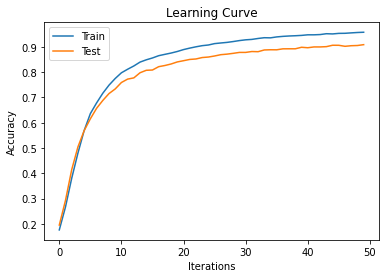

In [9]:
plt.title("Learning Curve")
plt.plot(np.arange(50),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(50),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

## SGD optimizer - Momentum
Momentum is a simple and easy improvement upon Stochastic Gradient Descent. It can accelerate gradient descent in the relevant direction.

In [10]:
cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [11]:
hist = cnn_model.fit(x_train, y_train,
              epochs=50,
              batch_size=64,
              validation_data=(x_test, y_test))

Epoch 1/50
94/94 [==============================] - 2s 13ms/step - loss: 0.2401 - accuracy: 0.9338 - val_loss: 0.3258 - val_accuracy: 0.9055
Epoch 2/50
94/94 [==============================] - 1s 14ms/step - loss: 0.1600 - accuracy: 0.9553 - val_loss: 0.3062 - val_accuracy: 0.9112
Epoch 3/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1344 - accuracy: 0.9598 - val_loss: 0.3232 - val_accuracy: 0.9123
Epoch 4/50
94/94 [==============================] - 1s 7ms/step - loss: 0.1192 - accuracy: 0.9672 - val_loss: 0.3063 - val_accuracy: 0.9183
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 0.1185 - accuracy: 0.9635 - val_loss: 0.3160 - val_accuracy: 0.9242
Epoch 6/50
94/94 [==============================] - 1s 11ms/step - loss: 0.0939 - accuracy: 0.9710 - val_loss: 0.3531 - val_accuracy: 0.9202
Epoch 7/50
94/94 [==============================] - 1s 9ms/step - loss: 0.0735 - accuracy: 0.9772 - val_loss: 0.3164 - val_accuracy: 0.9230
Epoch 8/50
94/94 

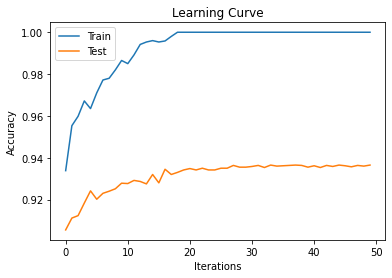

In [12]:
plt.title("Learning Curve")
plt.plot(np.arange(50),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(50),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

With a well-tuned learning-rate and momentum parameter, our training can go faster. You can see how the Accuracy is much higher in this example compared to the one before. (Note: We had to try a few settings before finding one that worked well, and encourage you to try different combinations of the learning rate and momentum.

## ⏰ Adam optimizer
The Adam optimizer works well and is the most popular optimizer nowadays. Adam typically requires a smaller learning rate: start at 0.001, then increase/decrease as you see fit. Please try to run the model with the adam optimizer.

In [13]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                     loss=tf.keras.losses.CategoricalCrossentropy(),
                     metrics=['accuracy'])

In [14]:
hist = cnn_model.fit(x_train, y_train,
              epochs=50,
              batch_size=64,
              validation_data=(x_test, y_test))

Epoch 1/50
94/94 [==============================] - 3s 15ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.5393 - val_accuracy: 0.9290
Epoch 2/50
94/94 [==============================] - 1s 8ms/step - loss: 0.0242 - accuracy: 0.9917 - val_loss: 0.4908 - val_accuracy: 0.9282
Epoch 3/50
94/94 [==============================] - 1s 8ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.4649 - val_accuracy: 0.9353
Epoch 4/50
94/94 [==============================] - 1s 8ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.4655 - val_accuracy: 0.9388
Epoch 5/50
94/94 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4514 - val_accuracy: 0.9387
Epoch 6/50
94/94 [==============================] - 1s 8ms/step - loss: 2.9150e-04 - accuracy: 1.0000 - val_loss: 0.4443 - val_accuracy: 0.9405
Epoch 7/50
94/94 [==============================] - 1s 7ms/step - loss: 1.9600e-04 - accuracy: 1.0000 - val_loss: 0.4501 - val_accuracy: 0.9403
Epoch 8/50


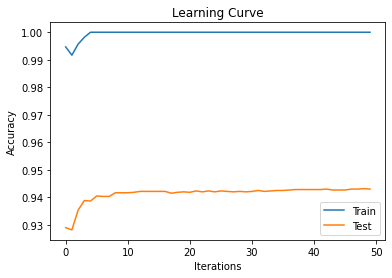

In [15]:
plt.title("Learning Curve")
plt.plot(np.arange(50),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(50),hist.history.get('val_accuracy'), label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()